## Data Preprocessing and Model Training

In [23]:
# General Libraries:
import cv2
import os
from PIL import Image
import numpy as np
from sklearn.utils import shuffle
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning libraries:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import regularizers



### Data Loading and Cleaning

In [2]:
def load_data(directory):
    images = []
    labels = []

    for label in os.listdir(directory):
        for image in os.listdir(os.path.join(directory, label)):
            img_path = os.path.join(directory, label, image)

            # Read and resize the image using Pillow
            img = Image.open(img_path)
            img_array = np.array(img)

            # Append the image array and the label to the lists
            images.append(img_array)
            labels.append(label)

    # Shuffle the arrays using sklearn.utils.shuffle
    images, labels = shuffle(images, labels, random_state=42)

    return images, labels

In [3]:
train_dir = r'C:\Users\andmpereira\OneDrive - Grupo Jerónimo Martins\Documentos\GitHub\DLNN-Group2\00 - Dataset\Training'
test_dir = r'C:\Users\andmpereira\OneDrive - Grupo Jerónimo Martins\Documentos\GitHub\DLNN-Group2\00 - Dataset\Testing'

# Load training data
train_images, train_labels = load_data(train_dir)

# Load testing data
test_images, test_labels = load_data(test_dir)

In [4]:
# Check data structure

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print("Number of Images in Train Set:", num_train_images)
print("Number of Labels in Train Set:", num_train_labels)
print("Number of Images in Test Set:", num_test_images)
print("Number of Labels in Test Set:", num_test_labels)

Number of Images in Train Set: 5712
Number of Labels in Train Set: 5712
Number of Images in Test Set: 1311
Number of Labels in Test Set: 1311


In [5]:
def remove_duplicates(images, labels):
    unique_pairs = set()
    unique_images = []
    unique_labels = []
    num_removed = 0

    for img, label in zip(images, labels):
        img_str = img.tobytes()
        pair = (img_str, label)

        # Check if the pair is unique
        if pair not in unique_pairs:
            unique_pairs.add(pair)
            unique_images.append(img)
            unique_labels.append(label)
        else:
            num_removed += 1

    print(f"Removed {num_removed} duplicate images.")
    
    return shuffle(unique_images, unique_labels, random_state=99)

In [6]:
# Remove duplicates from training data
train_images, train_labels = remove_duplicates(train_images, train_labels)

# Remove duplicates from testing data
test_images, test_labels = remove_duplicates(test_images, test_labels)

Removed 207 duplicate images.
Removed 30 duplicate images.


In [7]:
def print_class_distribution(labels, dataset_name):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    
    print(f"\nClass Distribution in {dataset_name} Dataset:")
    for class_label, count in zip(unique_classes, class_counts):
        print(f"Class {class_label}: {count} images")
    
    total_images = len(labels)
    print(f"Total number of images in {dataset_name} Dataset: {total_images}")

# Print training data class distribution
print_class_distribution(train_labels, 'Training')

# Print testing data class distribution
print_class_distribution(test_labels, 'Testing')



Class Distribution in Training Dataset:
Class glioma: 1321 images
Class meningioma: 1333 images
Class notumor: 1406 images
Class pituitary: 1445 images
Total number of images in Training Dataset: 5505

Class Distribution in Testing Dataset:
Class glioma: 299 images
Class meningioma: 301 images
Class notumor: 381 images
Class pituitary: 300 images
Total number of images in Testing Dataset: 1281


### Data Preprocessing

In [8]:
# Split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=99)


In [9]:
def preprocess_images(images, desired_size, normalize=True):
    preprocessed_images = []

    for img_array in images:
        # Convert numpy array to Pillow Image
        img = Image.fromarray(img_array)

        # Convert grayscale images to RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Resize the image
        img = img.resize(desired_size)

        # Convert the image back to a numpy array
        img_array = np.array(img)

        # Normalize pixel values to the range [0, 1]
        if normalize:
            img_array = img_array / 255.0

        preprocessed_images.append(img_array)

    return preprocessed_images

In [10]:
width = 224 
height = 224

train_images_processed = preprocess_images(train_images, desired_size=(width,height))
val_images_processed = preprocess_images(val_images, desired_size=(width,height))
test_images_processed = preprocess_images(test_images, desired_size=(width,height))

train_images_processed = np.array(train_images_processed)
val_images_processed = np.array(val_images_processed)

In [11]:

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

num_classes = len(label_encoder.classes_)

train_labels_one_hot = to_categorical(train_labels_encoded, num_classes=num_classes)
val_labels_one_hot = to_categorical(val_labels_encoded, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=num_classes)

### Data Augmentation

In [12]:
# Create an ImageDataGenerator with data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Preprocess and augment training data
train_generator = datagen.flow(np.array(train_images_processed), train_labels_one_hot, batch_size=32)
val_generator = val_datagen.flow(np.array(val_images_processed), val_labels_one_hot, batch_size=32)

### Model Architecture

In [13]:
# Define the CNN model
model = models.Sequential()

# Convolutional layer with 32 filters, 3x3 kernel, and ReLU activation
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# Max pooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional layer with 64 filters, 3x3 kernel, and ReLU activation
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Max pooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional layer with 128 filters, 3x3 kernel, and ReLU activation
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# Max pooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to convert 3D feature maps to 1D feature vectors
model.add(layers.Flatten())

# Dense layer with 128 neurons and ReLU activation
model.add(layers.Dense(128, activation='relu'))

# Output layer with 4 neurons (for 4 tumor types) and softmax activation
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
model.compile(RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [15]:
# Specify the number of training steps per epoch and validation steps
train_steps_per_epoch = len(train_generator)
val_steps_per_epoch = len(val_generator)

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,  # Adjust the number of epochs based on your needs
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch)

Epoch 1/10
138/138 [==============================] - ETA: 0s - loss: 1.2334 - accuracy: 0.3881

C:\Users\andmpereira\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


138/138 [==============================] - 325s 2s/step - loss: 1.2334 - accuracy: 0.3881 - val_loss: 0.9823 - val_accuracy: 0.5604
Epoch 2/10
138/138 [==============================] - 353s 3s/step - loss: 1.0151 - accuracy: 0.5645 - val_loss: 0.8921 - val_accuracy: 0.6440
Epoch 3/10
138/138 [==============================] - 375s 3s/step - loss: 0.9254 - accuracy: 0.6222 - val_loss: 0.8144 - val_accuracy: 0.6903
Epoch 4/10
138/138 [==============================] - 354s 3s/step - loss: 0.8699 - accuracy: 0.6469 - val_loss: 0.8907 - val_accuracy: 0.6394
Epoch 5/10
138/138 [==============================] - 368s 3s/step - loss: 0.8228 - accuracy: 0.6701 - val_loss: 1.1211 - val_accuracy: 0.6004
Epoch 6/10
138/138 [==============================] - 387s 3s/step - loss: 0.7923 - accuracy: 0.6839 - val_loss: 0.7903 - val_accuracy: 0.6948
Epoch 7/10
138/138 [==============================] - 472s 3s/step - loss: 0.7636 - accuracy: 0.7028 - val_loss: 0.6546 - val_accuracy: 0.7820
Epoch 8/10

In [16]:
val_metrics = model.evaluate(val_generator, steps=val_steps_per_epoch)
print("Validation Metrics:", val_metrics)

35/35 [==============================] - 17s 457ms/step - loss: 0.6826 - accuracy: 0.7502
Validation Metrics: [0.6825965046882629, 0.7502270936965942]


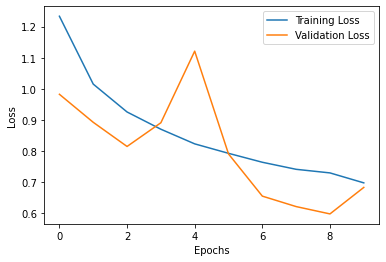

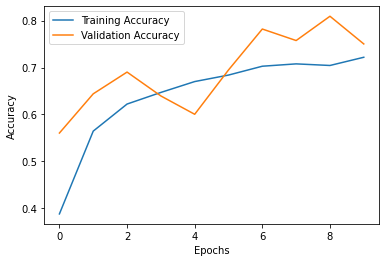

In [17]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
test_generator = val_datagen.flow(np.array(test_images_processed), test_labels_one_hot, batch_size=32)

test_steps_per_epoch = len(test_generator)
test_metrics = model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Metrics:", test_metrics)

41/41 [==============================] - 19s 435ms/step - loss: 0.9554 - accuracy: 0.7096
Test Metrics: [0.9554257392883301, 0.709601879119873]


41/41 [==============================] - 25s 604ms/step
Confusion Matrix:
[[178  29  14  78]
 [ 38  73  90 100]
 [  1   1 370   9]
 [  1   1  10 288]]


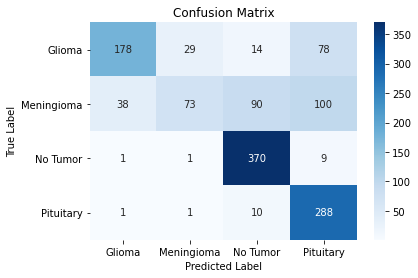

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.60      0.69       299
           1       0.70      0.24      0.36       301
           2       0.76      0.97      0.86       381
           3       0.61      0.96      0.74       300

    accuracy                           0.71      1281
   macro avg       0.72      0.69      0.66      1281
weighted avg       0.72      0.71      0.67      1281



In [22]:
# Get true labels
true_labels = []
for i in range(test_steps_per_epoch):
    _, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))

# Get predicted labels
predicted_labels = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma','Meningioma','No Tumor','Pituitary'], yticklabels=['Glioma','Meningioma','No Tumor','Pituitary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))



### Handling Overfitting

- Simplified the network to just 2 Conv2D with Max Pooling layers.
- Added Dropout and BatchNormalization
- Added L2 regularization
- Used Early Stopping to ensure improvement

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras import regularizers

# Define the CNN model
new_model = Sequential()

# Convolutional layer with 32 filters, 3x3 kernel, and ReLU activation
new_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# Max pooling layer_
new_model.add(MaxPooling2D((2, 2)))
new_model.add(BatchNormalization())

# Convolutional layer with 64 filters, 3x3 kernel, and ReLU activation
new_model.add(Conv2D(64, (3, 3), activation='relu'))
# Max pooling layer
new_model.add(MaxPooling2D((2, 2)))
new_model.add(BatchNormalization())
new_model.add(Dropout(0.2))  # Experiment with dropout rate

# Flatten layer to convert 3D feature maps to 1D feature vectors
new_model.add(Flatten())

# Dense layer with 128 neurons, ReLU activation, L2 regularization, and Batch Normalization
new_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
new_model.add(BatchNormalization())
new_model.add(Dropout(0.4))  # Experiment with dropout rate

# Output layer with 4 neurons (for 4 tumor types) and softmax activation
new_model.add(Dense(4, activation='softmax'))

# Compile the model with a lower learning rate
new_model.compile(RMSprop(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the updated model summary
new_model.summary()


In [ ]:

from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have your data generators and train/validation sets
# Replace 'train_generator' and 'val_generator' with your actual generators
train_steps_per_epoch = len(train_generator)
val_steps_per_epoch = len(val_generator)


# Compile the new model
new_model.compile(RMSprop(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the new model with early stopping
new_history = new_model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,  # Adjust the number of epochs based on your needs
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping]
)

In [ ]:
# Plot training history
plt.plot(new_history.new_history['loss'], label='Training Loss')
plt.plot(new_history.new_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(new_history.new_history['accuracy'], label='Training Accuracy')
plt.plot(new_history.new_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_metrics = new_model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Metrics:", test_metrics)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get true labels
true_labels = []
for i in range(test_steps_per_epoch):
    _, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))

# Get predicted labels
predicted_labels = new_model.predict(test_generator, steps=test_steps_per_epoch)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Get class indices from the test generator
class_indices = test_generator.class_indices

# Print class indices
print("Class Indices:")
print(class_indices)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# You can also visualize the confusion matrix using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

### HyperParameter Tunning

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam

# Function to create the model with hyperparameters as arguments
def create_model(optimizer='adam', learning_rate=0.00001, dropout_rate1=0.2, dropout_rate2=0.4):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate1))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate2))
    model.add(Dense(4, activation='softmax'))
    
    # Choose optimizer based on the parameter
    if optimizer == 'adam':
        model.compile(Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(RMSprop(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create KerasClassifier
keras_model = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)

# Define the parameter grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],  # Include both Adam and RMSprop optimizers
    'learning_rate': [0.00001, 0.0001, 0.001],
    'dropout_rate1': [0.2, 0.3, 0.4],
    'dropout_rate2': [0.3, 0.4, 0.5]
}

# Create GridSearchCV
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3)

# Perform grid search
grid_result = grid.fit(train_generator, steps_per_epoch=train_steps_per_epoch,
                       validation_data=val_generator, validation_steps=val_steps_per_epoch,
                       callbacks=[early_stopping])

# Print the best parameters and corresponding accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
